# Interactive Urban Flood Predictor

In [17]:
import tensorflow as tf
import numpy as np
import os
from os.path import join
import math

import matplotlib.pylab as plt
import cv2
import gzip
import pandas as pd

# import neural net code
import nn
import model_zurich.nn_model as nn_model
import featureExtraction as fe

# import ipywidgets (interaction library)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy.stats import norm

## 1. The CNN Model

In [15]:
# files
rain_file = "data_zurich/744/rain_pattern_str.txt"
dem_file = "data_zurich/744/dem/744_dem_asc.asc.gz"
waterdepth_path = "data_zurich/744/waterdepth"

model_path = "model"
model_name = "zurich-744_512_01"

In [4]:
# parameters
patch_num = 5000
patch_size = 512
input_channel = 6 # dem + mask + slope + cos + sin + curvature
output_channel = 1 # water level
vector_length = 12

lin_size = [4096] # 4096 = 32 * 32 * 4
reshape_size = [32,32,4] # reshape_size is determined by patch_size / pooling_size / .. / pooling_size, which is 32

net_channel = [32,64,128,128]
kernel_size = [[3,3],[3,3],[3,3],[3,3]]
pooling_size = [[2,2],[2,2],[2,2],[2,2]] # size of the latent layer: patch_size / pooling_size / .. / pooling_size = 32

# the cnn model used for training and testing
initializer = tf.contrib.layers.xavier_initializer()
af = tf.nn.leaky_relu
phs, ls, vs = nn_model.prediction_network_new([patch_size, patch_size, input_channel],vector_length, lin_size, reshape_size, net_channel, output_channel, kernel_size, pooling_size, initializer, af)

Tensor("encode-0:0", shape=(?, 256, 256, 32), dtype=float32)
Tensor("encode-1:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("encode-2:0", shape=(?, 64, 64, 128), dtype=float32)
Tensor("encode-3:0", shape=(?, 32, 32, 128), dtype=float32)
Tensor("l-0:0", shape=(?, 4096), dtype=float32)
Tensor("concat:0", shape=(?, 32, 32, 132), dtype=float32)
Tensor("decode-3:0", shape=(?, 64, 64, 32), dtype=float32)
Tensor("decode-2:0", shape=(?, 128, 128, 64), dtype=float32)
Tensor("decode-1:0", shape=(?, 256, 256, 128), dtype=float32)
Tensor("decode-0:0", shape=(?, 512, 512, 1), dtype=float32)


## 2.  Load Data

### 2.1 Functions

In [5]:
def load_waterdepth(foldername, pattern_name_list):
    '''
    load the simulation results from a specific folder
    
    the result will be a list of numpy array
    '''
    files = os.listdir(foldername)
    waterdepth = []
    
    for pattern_name in pattern_name_list:
        pattern_file = None
        for f in files:
            if "_" + pattern_name + "_" in f:
                pattern_file = f
                break
        if pattern_file is None:
            raise Exception("cannot find simulation result for pattern " + pattern_name)
            
        print("loading",pattern_file)
        
        if ".gz" in pattern_file:
            with gzip.open(join(foldername,pattern_file),"rb") as pattern_file_gzip:
                wd = read_ASC(pattern_file_gzip)
                # some asc file contains empty columns, delete them
                if np.any(np.isnan(wd[:,-1])):
                    wd = wd[:,:-1]
                print (wd.shape)
                # we define that the prediction value for invalid area is always 0
                wd[wd<0]=0
                waterdepth.append(wd)
        else:
            wd = read_ASC(join(foldername,pattern_file))
            # some asc file contains empty columns, delete them
            if np.any(np.isnan(wd[:,-1])):
                wd = wd[:,:-1]
            print (wd.shape)
            # we define that the prediction value for invalid area is always 0
            wd[wd<0]=0
            waterdepth.append(wd)
    
    if len(waterdepth) == 1:
        return waterdepth[0]
    else:
        return np.transpose(np.array(waterdepth),[1,2,0])

def load_dem(dem_file):
    print("loading", dem_file)
    dem_array = None
    if ".gz" in dem_file:
        with gzip.open(dem_file,"rb") as zipfile:
            dem_array = read_ASC(zipfile,skip_last_col=False)
    else:
        dem_array = read_ASC(dem_file,skip_last_col=False)
    
    # some asc file contains empty columns, delete them
    if np.any(np.isnan(dem_array[:,-1])):
        dem_array = dem_array[:,:-1]
    print (dem_array.shape)
    return dem_array
    
def generate_features(dem_array):
    '''
    generate the necessary features from the dem
    
    the result will be an nd array [height, width, channel]
    '''
        
    print("generating features")
    
    slop,curvature,cos,sin,_ = fe.feature_lin_mean(dem_array,1)
    
    # rescale dem_array
    mask_indice = dem_array > 0
    
    vmin=dem_array[mask_indice].min()
    vmax=dem_array[mask_indice].max()
    
    dem_array[mask_indice] -= vmin
    dem_array[mask_indice] /= (vmax - vmin)
    
    # fill non-data areas
    mask_indice = dem_array < 0
    dem_array[mask_indice] = 0
    
    # mask
    mask_array = np.ones_like(dem_array,dtype=np.float32)
    mask_array[mask_indice] = -1
    
    # final output of dem
    return np.transpose(np.array([dem_array,mask_array,slop,cos,sin,curvature]),[1,2,0])

In [11]:
# asc loading functions
def read_ASC(file, skip_last_col=False):
    if skip_last_col:
        return pd.read_csv(file,header=None,skiprows=6,delimiter=" ",skipinitialspace =True,dtype=np.float32).values[:,:-1]
    else:
        return pd.read_csv(file,header=None,skiprows=6,delimiter=" ",skipinitialspace =True,dtype=np.float32).values
    
def read_CSV(file, delimiter=",", skip_last_col=False):
    if skip_last_col:
        return pd.read_csv(file,header=None,skiprows=0,delimiter=delimiter,skipinitialspace =True).values[:,:-1]
    else:
        return pd.read_csv(file,header=None,skiprows=0,delimiter=delimiter,skipinitialspace =True).values

def rainfall_pattern(rain_file):
    data = pd.read_csv(rain_file,header=None,index_col=0,delimiter="\t",skipinitialspace =True)
    values = data.values
    return {i:data.index[i] for i in range(len(data.index))},values

### 2.2 Restore CNN Model

In [6]:
model_id = "/-79"

sess=tf.Session()
tf.global_variables_initializer().run(session=sess)
saver = tf.train.Saver()
saver.restore(sess,join(model_path,model_name+model_id))

INFO:tensorflow:Restoring parameters from model\zurich-744_512_01/-79


### 2.3 Load DEM Data

In [18]:
dem_array = load_dem(dem_file)
mask_indice = dem_array<0
dem_array = generate_features(dem_array)

loading data_zurich/dem/744_dem_asc.asc.gz
generating features


### 2.4 Load Rainfall Data

In [19]:
rainfall_name, rainfall_intensity = rainfall_pattern(rain_file)

## 3. Make Predictions

### 3.1 Functions

In [28]:
def make_prediction_random_patches(dem_array, rain_pattern_vector, batch_size=32):
    '''
    calculate the mean value of randomly positioned prediction patches and return the result as the final prediction
    
    this method is computationally heavier but produce more stable result
    '''
    height, width, _ = dem_array.shape
    
    # necessary data for prediction
    max_x = np.zeros((height,width), dtype=np.float32)
    sum_x = np.zeros((height,width), dtype=np.float32)
    sum_x2 = np.zeros((height,width), dtype=np.float32)
    n_x = np.zeros((height,width), dtype=np.float32)
    stddev = np.zeros((height,width), dtype=np.float32)
    
    # generate patch locations
    num_patches = max(batch_size, 3 * math.ceil((height*width)/(patch_size**2)))
    
    patches=[]
    i=0
    while i < num_patches:
        w = np.random.randint(width - patch_size)
        h = np.random.randint(height - patch_size)
        
        if not np.any(dem_array[h:h+patch_size,w:w+patch_size,0]):
            continue
        
        i+=1
        
        patches.append([h,w]) 
    patches = np.array(patches,dtype=np.uint32)
    
    print("testing")

    for i in range(0, num_patches, batch_size):
        start = i
        end = min(i+batch_size, num_patches-1)
        print(start,end,num_patches)

        x1 = np.array([dem_array[patches[j,0]:patches[j,0]+patch_size,patches[j,1]:patches[j,1]+patch_size] for j in range(start,end)])
        x2 = np.array([rain_pattern_vector for _ in range(end-start)])

        result = sess.run(ls["prediction"], feed_dict={phs["x1"]:x1,phs["x2"]:x2})

        for j in range(end-start):
            h,w = patches[start + j]

            max_x[h:h+patch_size,w:w+patch_size] = np.maximum(max_x[h:h+patch_size,w:w+patch_size],result[j])
            sum_x[h:h+patch_size,w:w+patch_size] += result[j]
            sum_x2[h:h+patch_size,w:w+patch_size] += np.square(result[j])
            n_x[h:h+patch_size,w:w+patch_size] += 1
    
    mean_x = np.copy(sum_x)
    mean_x[n_x>0] /= n_x[n_x>0]
    
    mask_indice_inv = n_x > 0
    stddev[mask_indice_inv] = np.sqrt(sum_x2[mask_indice_inv]/n_x[mask_indice_inv] - np.square(sum_x[mask_indice_inv]/n_x[mask_indice_inv]))
    
    return mean_x, stddev

In [29]:
def make_prediction_grid(dem_array, rain_pattern_vector, batch_size=32):
    '''
    calculate the mean value of grid positioned prediction patches (which minimize the number of patches
    needed to cover the entire catchment area) and return the result as the final prediction
    '''
    height, width, _ = dem_array.shape
    
    # necessary data for prediction
    max_x = np.zeros((height,width), dtype=np.float32)
    sum_x = np.zeros((height,width), dtype=np.float32)
    sum_x2 = np.zeros((height,width), dtype=np.float32)
    n_x = np.zeros((height,width), dtype=np.float32)
    stddev = np.zeros((height,width), dtype=np.float32)
    
    # generate patch locations
    patches = [[min(h,height-patch_size-1),min(w,width - patch_size-1)] for h in range(0, height-patch_size,patch_size) for w in range(0, width - patch_size, patch_size)]
    # select those that contains catchment areas
    patches = [[h, w] for h, w in patches if np.any(dem_array[h:h+patch_size,w:w+patch_size,0])]
    num_patches = len(patches)
    patches = np.array(patches,dtype=np.uint32)
    
    print("testing")

    for i in range(0, num_patches, batch_size):
        start = i
        end = min(i+batch_size, num_patches-1)
        print(start,end,num_patches)

        x1 = np.array([dem_array[patches[j,0]:patches[j,0]+patch_size,patches[j,1]:patches[j,1]+patch_size] for j in range(start,end)])
        x2 = np.array([rain_pattern_vector for _ in range(end-start)])

        result = sess.run(ls["prediction"], feed_dict={phs["x1"]:x1,phs["x2"]:x2})

        for j in range(end-start):
            h,w = patches[start + j]

            max_x[h:h+patch_size,w:w+patch_size] = np.maximum(max_x[h:h+patch_size,w:w+patch_size],result[j])
            sum_x[h:h+patch_size,w:w+patch_size] += result[j]
            sum_x2[h:h+patch_size,w:w+patch_size] += np.square(result[j])
            n_x[h:h+patch_size,w:w+patch_size] += 1
    
    mean_x = np.copy(sum_x)
    mean_x[n_x>0] /= n_x[n_x>0]
    
    mask_indice_inv = n_x > 0
    stddev[mask_indice_inv] = np.sqrt(sum_x2[mask_indice_inv]/n_x[mask_indice_inv] - np.square(sum_x[mask_indice_inv]/n_x[mask_indice_inv]))
    
    return mean_x, stddev

In [55]:
def render_prediction(mask_indice, output, rain_pattern_vector, target_array=None, img_height = 20):
    height, width = output.shape
    
    output[mask_indice]=np.nan
    stddev[mask_indice]=np.nan
    
    if target_array is None:    
        plt.figure(figsize=(2 * math.ceil(width / height * img_height),img_height))
        plt.subplot(1,2,1)
        plt.gca().set_title("rainfall pattern")
        plt.plot(rain_pattern_vector)
        
        plt.subplot(1,2,2)
        plt.gca().set_title("prediction")
        plt.imshow(output, cmap=plt.cm.terrain,vmin=0,vmax=5)

    else:
        target_array[mask_indice]=np.nan
        
        plt.figure(figsize=(2 * math.ceil(width / height * img_height),2 * img_height))
        plt.subplot(2,2,1)
        plt.gca().set_title("prediction")
        plt.imshow(output, cmap=plt.cm.terrain,vmin=0,vmax=5)
        
        plt.subplot(2,2,2)
        plt.gca().set_title("target")
        plt.imshow(target_array, cmap=plt.cm.terrain,vmin=0,vmax=5)
        
        plt.subplot(2,2,3)
        plt.gca().set_title("rainfall pattern")
        plt.plot(rain_pattern_vector)
        
        plt.subplot(2,2,4)
        plt.gca().set_title("error [-1, 1]")
        plt.imshow(target_array - output, cmap=plt.cm.seismic,vmin=-1,vmax=1)
    plt.show()

### 3.2 On Generated Rain Pattern

In [36]:
def generate_rain_pattern(mu,sigma,minval,maxval):
    n=nn_model.PATTERN_RESOLUTION
    pattern=norm.pdf(np.arange(n)/(n-1) * 10,mu,sigma)
    pattern/=np.max(pattern)
    pattern*=(maxval-minval)
    pattern+=minval
    
    mean_x, _ = make_prediction_grid(dem_array, pattern)
    render_prediction(mask_indice, mean_x, pattern)

testing
0 32 70
32 64 70
64 69 70


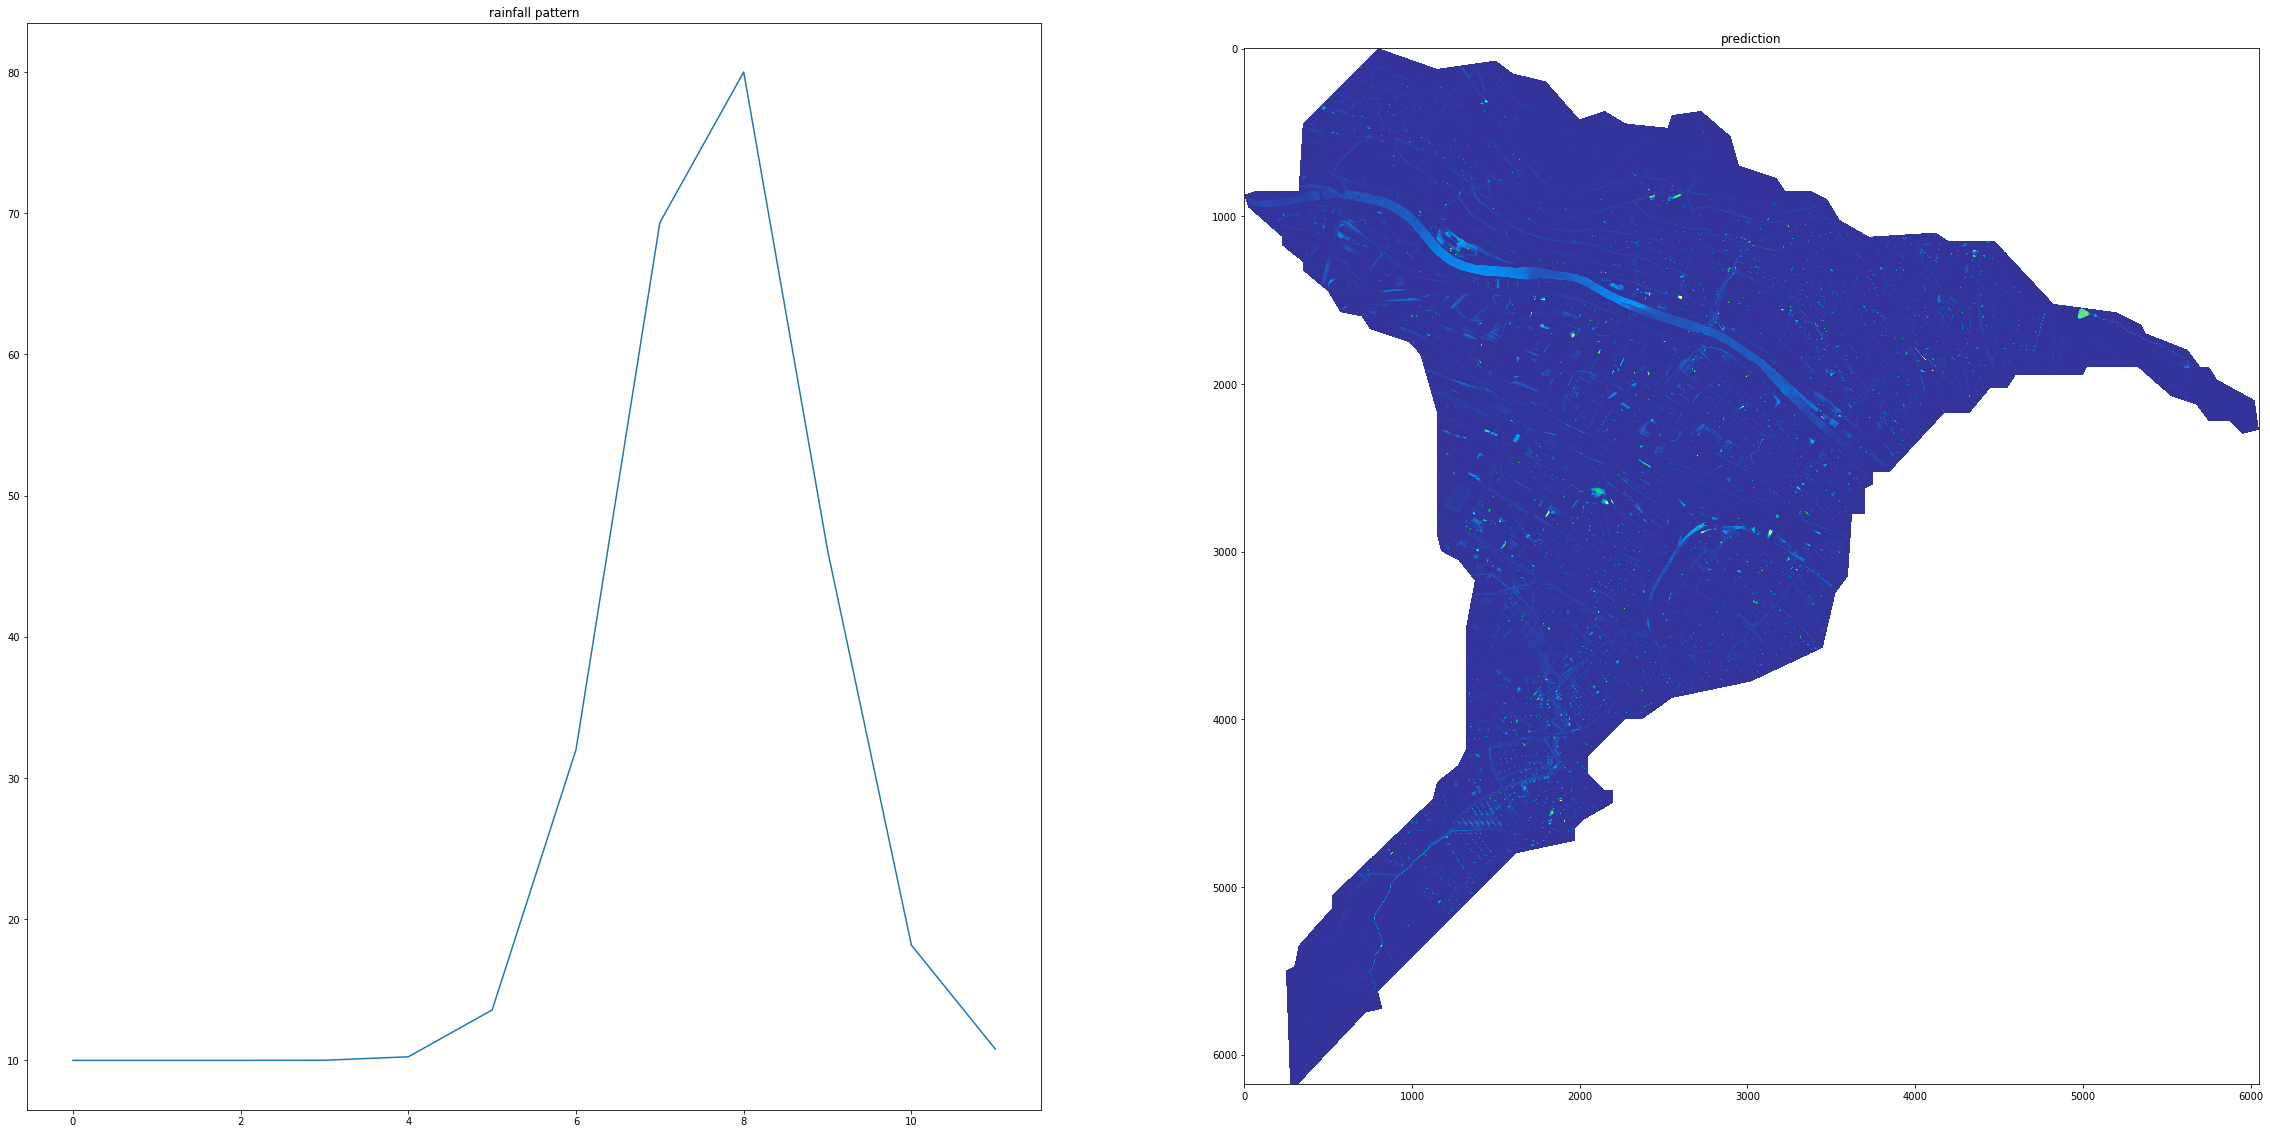

In [37]:
generate_rain_pattern(7,1,10,80)

interactive version

In [38]:
interact(generate_rain_pattern,mu=widgets.FloatSlider(min=0,max=nn_model.PATTERN_RESOLUTION,step=0.5,value=nn_model.PATTERN_RESOLUTION/2),sigma=widgets.FloatSlider(min=0.1,max=2,step=0.1,value=0.1),minval=widgets.IntSlider(min=0,max=40,step=10,value=20),maxval=widgets.IntSlider(min=80,max=160,step=10,value=80))

interactive(children=(FloatSlider(value=6.0, description='mu', max=12.0, step=0.5), FloatSlider(value=0.1, des…

<function __main__.generate_rain_pattern>

### 3.3 On Testset

In [40]:
random_seed = 1 # random seed used for training the model

np.random.seed(random_seed)

rainfall_index = np.array([k for k in rainfall_name.keys()],dtype=np.int32)

np.random.shuffle(rainfall_index)
test_pattern_index = rainfall_index[:len(rainfall_index)//3] # 6
test_pattern_name = [rainfall_name[i] for i in test_pattern_index]

print(test_pattern_index, test_pattern_name)
# should be [ 6  3 13  2 14  7] ['tr2-2', 'tr20', 'tr5-3', 'tr10', 'tr10-3', 'tr5-2']

[ 6  3 13  2 14  7] ['tr2-2', 'tr20', 'tr5-3', 'tr10', 'tr10-3', 'tr5-2']


In [51]:
def test_rain_pattern(pattern_index):
    pattern=rainfall_intensity[pattern_index]
    target_array = load_waterdepth(waterdepth_path, [rainfall_name[pattern_index]])
    
    mean_x, _ = make_prediction_grid(dem_array, pattern)
    render_prediction(mask_indice, mean_x, pattern, target_array = target_array)

loading 744_tr20_WDraster_PEAK.asc.gz
testing
0 32 70
32 64 70
64 69 70


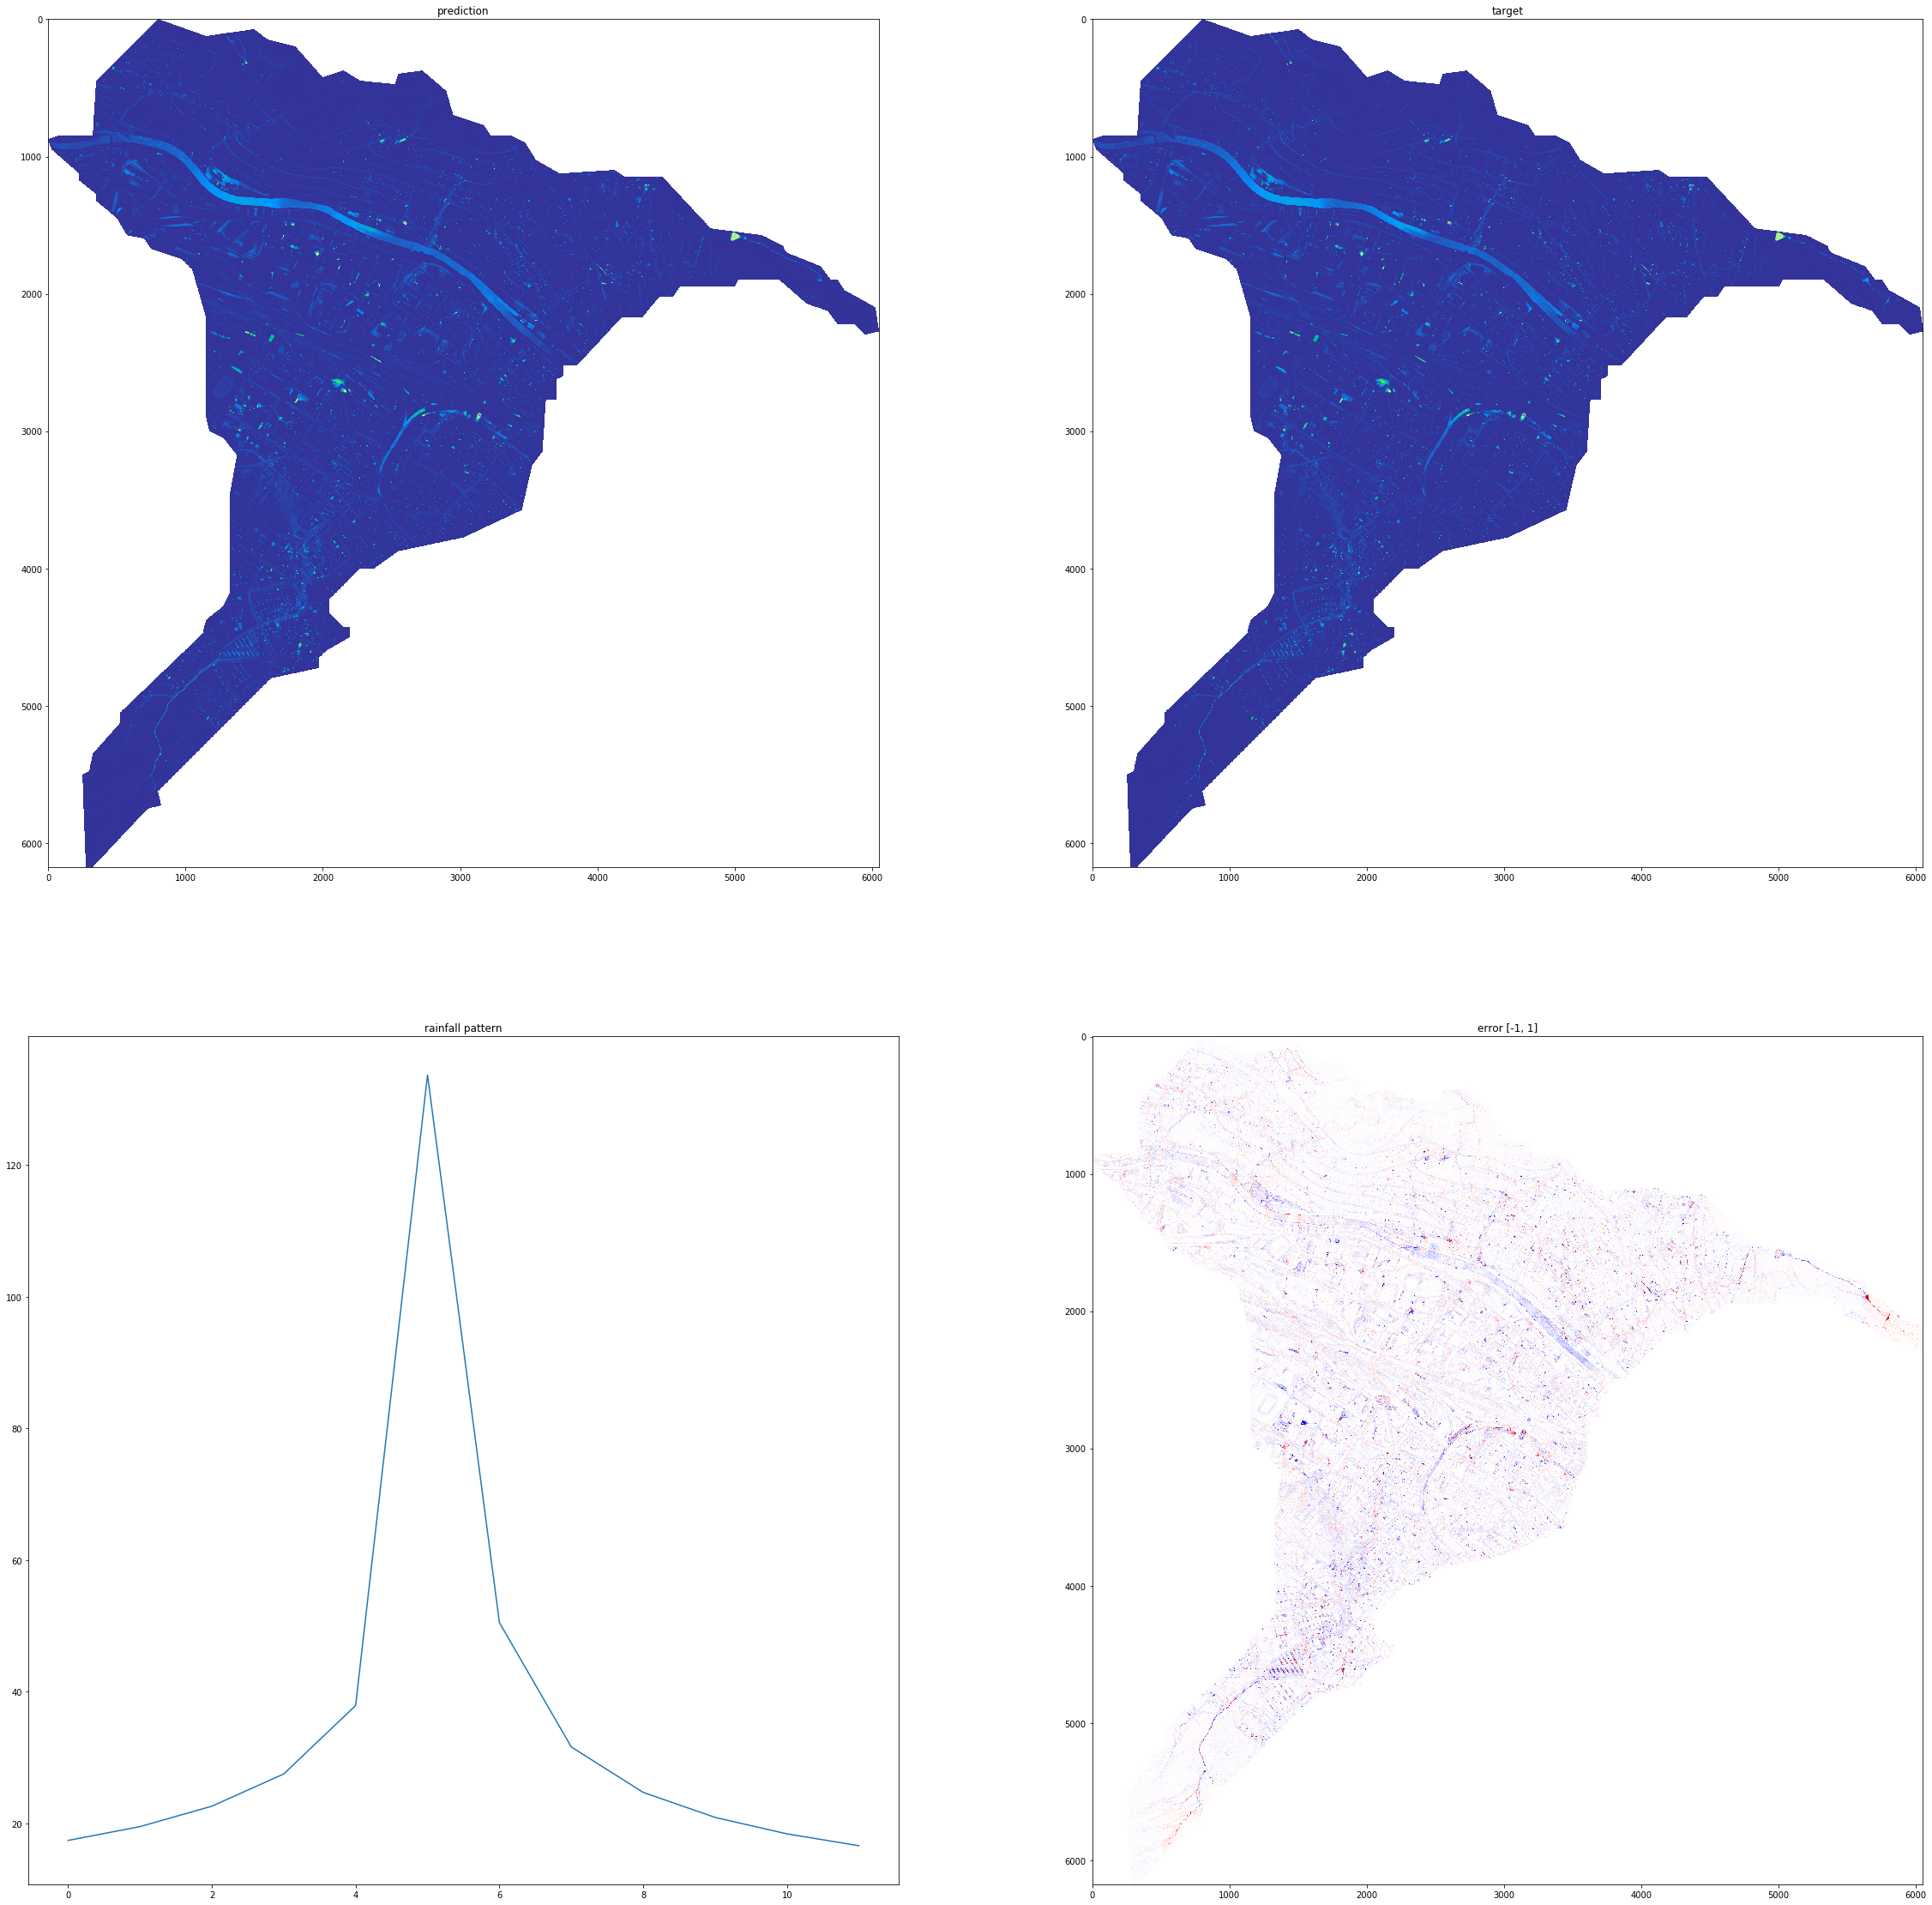

In [56]:
test_rain_pattern(3)

In [63]:
interact(test_rain_pattern,pattern_index=[[test_pattern_name[i],test_pattern_index[i]] for i in range(len(test_pattern_index))])

interactive(children=(Dropdown(description='pattern_index', options=(['tr2-2', 6], ['tr20', 3], ['tr5-3', 13],…

<function __main__.test_rain_pattern>